# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [58]:
LV_NAME = "LV948"

In [59]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 15

In [60]:
# OUTPUT_FIGURES_DIR = Path(
#     conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
# ).resolve()
# display(OUTPUT_FIGURES_DIR)
# OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [61]:
# OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
# display(OUTPUT_CELL_TYPE_FILEPATH)

# Load MultiPLIER summary

In [62]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [63]:
multiplier_model_summary.shape

(2157, 5)

In [64]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [65]:
INPUT_SUBSET = "z_score_std"

In [66]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [67]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases/phenoplier/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [68]:
data = pd.read_pickle(input_filepath)

In [69]:
data.shape

(3752, 987)

In [70]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [71]:
lv_obj = LVAnalysis(LV_NAME, data)

In [101]:
lv_obj.lv_genes.head(20)

,gene_name,LV948,gene_band
0,IL4I1,4.351663,19q13.33
1,IL23R,3.856019,1p31.3
2,TNFRSF25,3.592262,1p36.31
3,PTGDR,2.847765,14q22.1
4,CD2,2.831283,1p13.1
5,KIT,2.654972,4q12
6,CCR6,2.577751,6q27
7,LST1,2.510592,6p21.33
8,IL7R,2.331007,5p13.2
9,TNFSF11,2.204685,13q14.11


In [72]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

,pathway,LV index,AUC,p-value,FDR


In [73]:
lv_data = lv_obj.get_experiments_data()

SRP060416, SRP057196, SRP014428, SRP055569, SRP033135, SRP018853, SRP013363, SRP042161, SRP066834, SRP024244, SRP050499, SRP009247, SRP045711, SRP012461, SRP036821, SRP055153, SRP064464, 

In [74]:
lv_data.shape

(4870, 41)

In [75]:
lv_data.head()

tonsil donor facs gating                     cell type  \
project   run                                                                 
SRP060416 SRR2088096    Donor T74          NK  tonsil Innate lymphoid cells   
          SRR2088128    Donor T74        ILC3  tonsil Innate lymphoid cells   
          SRR2088153    Donor T75        ILC3  tonsil Innate lymphoid cells   
          SRR2088179    Donor T75        ILC3  tonsil Innate lymphoid cells   
          SRR2088205    Donor T75        ILC3  tonsil Innate lymphoid cells   

                     tissue  age c1 chip id experiment_sample_name cell line  \
project   run                                                                  
SRP060416 SRR2088096    NaN  NaN        NaN                    NaN       NaN   
          SRR2088128    NaN  NaN        NaN                    NaN       NaN   
          SRR2088153    NaN  NaN        NaN                    NaN       NaN   
          SRR2088179    NaN  NaN        NaN                    NaN       NaN   
          SRR2088205    NaN  NaN        NaN                    NaN       NaN   

                     sample type hour post serum-switch  ...  \
project   run                                            ...   
SRP060416 SRR2088096         NaN                    NaN  ...   
          SRR2088128         NaN                    NaN  ...   
          SRR2088153         NaN                    NaN  ...   
          SRR2088179         NaN                    NaN  ...   
          SRR2088205         NaN                    NaN  ...   

                     patient code name tissue subtype tissue archive method  \
project   run                                                                 
SRP060416 SRR2088096               NaN            NaN                   NaN   
          SRR2088128               NaN            NaN                   NaN   
          SRR2088153               NaN            NaN                   NaN   
          SRR2088179               NaN            NaN                   NaN   
          SRR2088205               NaN            NaN                   NaN   

                     source assigned cell type qc pass cell count ercc_mix  \
project   run                                                                
SRP060416 SRR2088096    NaN                NaN     NaN        NaN      NaN   
          SRR2088128    NaN                NaN     NaN        NaN      NaN   
          SRR2088153    NaN                NaN     NaN        NaN      NaN   
          SRR2088179    NaN                NaN     NaN        NaN      NaN   
          SRR2088205    NaN                NaN     NaN        NaN      NaN   

                     ercc_dilution     LV948  
project   run                                 
SRP060416 SRR2088096           NaN -0.035633  
          SRR2088128           NaN  0.114710  
          SRR2088153           NaN  0.297828  
          SRR2088179           NaN  0.309819  
          SRR2088205           NaN  0.186832  

[5 rows x 41 columns]

# LV cell types analysis

## Get top attributes

In [76]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

tonsil donor                   0.141986
facs gating                    0.141986
time in culture                0.039762
cell sorted                    0.039762
cell type                      0.039389
cell line stably expressing    0.004221
par-clip antibody              0.004221
culture medium                 0.004221
age                            0.002718
c1 chip id                     0.002718
experiment_sample_name         0.002718
isolate                        0.002407
brain region                   0.002407
tissue                         0.001968
ercc_mix                       0.001612
ercc_dilution                  0.001612
cell count                     0.001612
qc pass                        0.001612
assigned cell type             0.001612
Stage                          0.001534
dtype: float64

In [77]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type         0.039389
tissue            0.001968
tissue subtype    0.001159
dtype: float64

In [78]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "tissue subtype",
        LV_NAME,
    ],
]

In [79]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [80]:
_tmp_seq[10]

cell type  \
project   run                                                             
SRP060416 SRR2088647                       tonsil Innate lymphoid cells   
          SRR2088693                       tonsil Innate lymphoid cells   
          SRR2088098                       tonsil Innate lymphoid cells   
          SRR2088113                       tonsil Innate lymphoid cells   
          SRR2088454                       tonsil Innate lymphoid cells   
SRP014428 SRR522080          leukocyte from blood of healthy individual   
SRP060416 SRR2088201                       tonsil Innate lymphoid cells   
          SRR2088534                       tonsil Innate lymphoid cells   
          SRR2088206                       tonsil Innate lymphoid cells   
          SRR2088474                       tonsil Innate lymphoid cells   
          SRR2088171                       tonsil Innate lymphoid cells   
          SRR2088308                       tonsil Innate lymphoid cells   
          SRR2088265                       tonsil Innate lymphoid cells   
          SRR2088435                       tonsil Innate lymphoid cells   
          SRR2088253                       tonsil Innate lymphoid cells   
          SRR2088427                       tonsil Innate lymphoid cells   
          SRR2088383                       tonsil Innate lymphoid cells   
          SRR2088566                       tonsil Innate lymphoid cells   
          SRR2088160                       tonsil Innate lymphoid cells   
          SRR2088143                       tonsil Innate lymphoid cells   
          SRR2088608                       tonsil Innate lymphoid cells   
SRP055569 SRR2018980  mixture of U87 human glioma cells and MCF10a h...   
SRP060416 SRR2088193                       tonsil Innate lymphoid cells   
          SRR2088280                       tonsil Innate lymphoid cells   
          SRR2088654                       tonsil Innate lymphoid cells   

                     tissue tissue subtype     LV948  
project   run                                         
SRP060416 SRR2088647    NaN            NaN  0.297322  
          SRR2088693    NaN            NaN  0.288883  
          SRR2088098    NaN            NaN  0.287462  
          SRR2088113    NaN            NaN  0.286754  
          SRR2088454    NaN            NaN  0.285826  
SRP014428 SRR522080     NaN            NaN  0.282108  
SRP060416 SRR2088201    NaN            NaN  0.280592  
          SRR2088534    NaN            NaN  0.279547  
          SRR2088206    NaN            NaN  0.277616  
          SRR2088474    NaN            NaN  0.277312  
          SRR2088171    NaN            NaN  0.276612  
          SRR2088308    NaN            NaN  0.276513  
          SRR2088265    NaN            NaN  0.267213  
          SRR2088435    NaN            NaN  0.262731  
          SRR2088253    NaN            NaN  0.259416  
          SRR2088427    NaN            NaN  0.253241  
          SRR2088383    NaN            NaN  0.247422  
          SRR2088566    NaN            NaN  0.244143  
          SRR2088160    NaN            NaN  0.242614  
          SRR2088143    NaN            NaN  0.242290  
          SRR2088608    NaN            NaN  0.239752  
SRP055569 SRR2018980    NaN            NaN  0.237746  
SRP060416 SRR2088193    NaN            NaN  0.237343  
          SRR2088280    NaN            NaN  0.236237  
          SRR2088654    NaN            NaN  0.234276

In [81]:
# # what is there in these projects?
# lv_data.loc[["SRP007412"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).sort_values(LV_NAME, ascending=False).head(10)

**No cell types/tissues/cell lines** so not very interesting

In [82]:
SELECTED_ATTRIBUTE = "cell type"

In [83]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "tissue subtype"]

## Get plot data

In [84]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [85]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [86]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [87]:
plot_data.head(20)

cell type     LV948
project   run                                               
SRP060416 SRR2088191  tonsil Innate lymphoid cells  2.573508
          SRR2088107  tonsil Innate lymphoid cells  2.172393
          SRR2088237  tonsil Innate lymphoid cells  1.828542
          SRR2088099  tonsil Innate lymphoid cells  1.581172
          SRR2088182  tonsil Innate lymphoid cells  1.506301
          SRR2088189  tonsil Innate lymphoid cells  1.464860
          SRR2088146  tonsil Innate lymphoid cells  1.430411
          SRR2088276  tonsil Innate lymphoid cells  1.404662
          SRR2088129  tonsil Innate lymphoid cells  1.372129
          SRR2088208  tonsil Innate lymphoid cells  1.301686
          SRR2088134  tonsil Innate lymphoid cells  1.196603
          SRR2088165  tonsil Innate lymphoid cells  1.195534
          SRR2088100  tonsil Innate lymphoid cells  1.185359
          SRR2088119  tonsil Innate lymphoid cells  1.160231
          SRR2088112  tonsil Innate lymphoid cells  1.137457
          SRR2088162  tonsil Innate lymphoid cells  1.128935
          SRR2088084  tonsil Innate lymphoid cells  1.092478
          SRR2088490  tonsil Innate lymphoid cells  1.082059
          SRR2088122  tonsil Innate lymphoid cells  1.072699
          SRR2088101  tonsil Innate lymphoid cells  1.047875

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [88]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            #             "normal skin": "Skin",
            #             "liver": "Liver",
            #             "Human Skeletal Muscle Myoblasts (HSMM)": "Skeletal muscle myoblasts",
            #             "astrocytes": "Astrocytes",
            #             "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            #             "functional hepatocytes generated by lineage reprogramming": "Hepatocytes",
            #             "human adipose-derived stem cells": "Adipose-derived stem cells",
            #             "adipose": "Adipose",
            #             "embryonic stem cells": "Embryonic stem cells",
            #             "primary keratinocytes": "Primary keratinocytes",
            #             "fetal liver": "Fetal liver",
            #             "in vitro differentiated erythroid cells": "Erythroid cells",
            #             "WAT": "White adipose tissue",
            #             "BAT": "Brown adipose tissue",
            #             "Uninvolved Breast Tissue Adjacent to ER+ Primary Tumor": "Breast tissue adjacent to ER+ tumor",
            #             "ovarian granulosa cells": "Ovarian granulosa cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "glioma cells + breast cancer cells",
        }
    }
)

In [89]:
# add also tissue information to these projects
_srp_code = "SRP057196"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-89-6f1c7e491b69>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [90]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [91]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [92]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [93]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [94]:
len(attr_order)

15

In [95]:
attr_order[:5]

['tonsil Innate lymphoid cells',
 'astrocytes (cortex)',
 'neurons (cortex)',
 'leukocyte from blood of healthy individual',
 'glioma cells + breast cancer cells']

## Plot

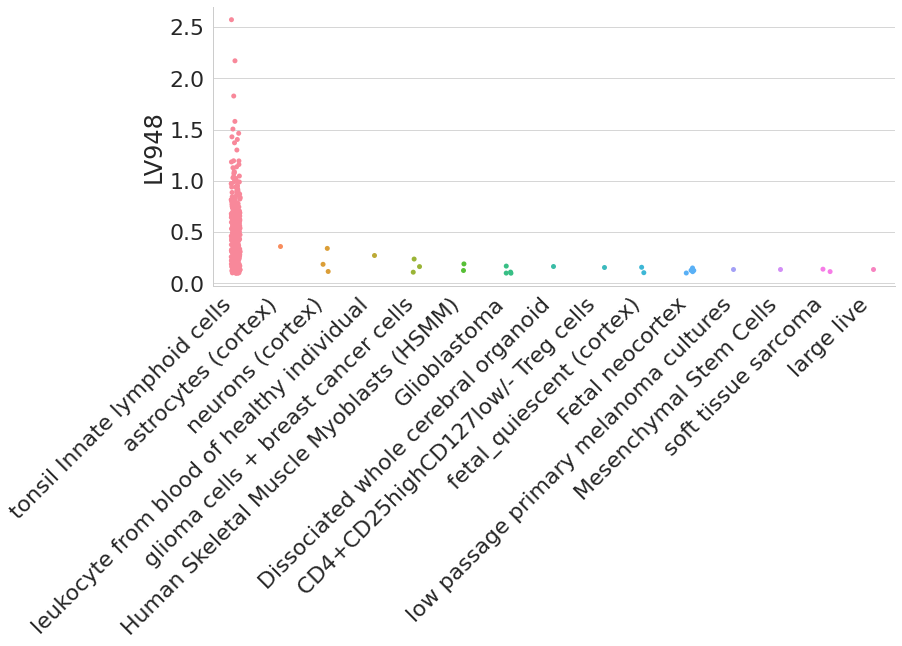

In [96]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=2.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

#     plt.savefig(
#         OUTPUT_CELL_TYPE_FILEPATH,
#         bbox_inches="tight",
#         facecolor="white",
#     )

# Debug

In [97]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("mixture")]
    display(_tmp.head(20))

,,cell type,LV948
project,run,,
SRP055569,SRR2019221,mixture of U87 human glioma cells and WI-38 human lung fibroblast cells,0.102567


In [98]:
# # what is there in these projects?
# lv_data.loc[["SRP056041"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)